In [1]:
suppressPackageStartupMessages({
  library(Seurat)
  library(ggplot2)
  library(dplyr)
  library(pagoda2)
  library(cowplot)
  library(magrittr)
  library(ggrastr)
  library(data.table)
  library(dataorganizer)
  library(devtools)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
sos <- prepare_OC_sc_spatial(load_molecules=FALSE)
so_rna <- sos$so_rna
so_spatial <- sos$so_spatial

In [3]:
# make pagoda objects for the sc and spatial datasets
sc_counts <- so_rna[['RNA']]$counts
rownames(sc_counts) <- rownames(so_rna)
colnames(sc_counts) <- colnames(so_rna)

spatial_counts <- so_spatial[['RNA']]$counts
rownames(spatial_counts) <- rownames(so_spatial)
colnames(spatial_counts) <- colnames(so_spatial)

sc_obj <- Pagoda2$new(sc_counts, log.scale=TRUE, n.cores=20)
spatial_obj <- Pagoda2$new(spatial_counts, log.scale=TRUE, n.cores=20)

15372 cells, 4912 genes; normalizing ... 

Using plain model 

log scale ... 

done.


352670 cells, 4912 genes; normalizing ... 

Using plain model 

log scale ... 

done.




In [4]:
# run DE
ct_annot <- as.factor(so_rna$cell_type)
names(ct_annot) <- rownames(so_rna@meta.data)
de_out_mark <- sc_obj$getDifferentialGenes(verbose=TRUE,groups=ct_annot,z.threshold = 0,
                                            upregulated.only=TRUE,append.auc = TRUE)

# put into a table
de_genes <- lapply(1:length(de_out_mark),function(i){
  ct_nm <- names(de_out_mark)[i]
  x <- de_out_mark[[i]]

  # add pvalues
  x$padj <- 2*pnorm(abs(x$Z), mean = 0, sd = 1, lower.tail = FALSE)

  x$cell_type <- ct_nm
  rownames(x) <- NULL
  return(x)
})

running differential expression with 16 clusters ... 

adjusting p-values ... 

done.




In [5]:
de_genes_full1 <- do.call("rbind.data.frame",de_genes)

# subset to same genes in spatial data
de_genes_full1 <- de_genes_full1[de_genes_full1$Gene %in% rownames(so_spatial),]

In [6]:
# save full de results
write_rds(de_genes_full1, CachePath('OC_de_dat_full.rds'))

In [7]:
# subset to significant results only
de_genes_full1 <- de_genes_full1[de_genes_full1$padj<.05,]
de_genes_full1 <- de_genes_full1[de_genes_full1$AUC>.65,]
# de_genes_full1 <- de_genes_full1[de_genes_full1$Specificity>.95,]
de_genes_full1 <- de_genes_full1[de_genes_full1$Specificity>.85,]

# keeping only cell types also in spatial
cells_keep <- rownames(so_rna@meta.data)[so_rna@meta.data$cell_type %in% unique(so_spatial$cell_type)]
so_rna <- subset(so_rna,cells=cells_keep)

# order by AUC
de_genes_full1 <- de_genes_full1[order(de_genes_full1$AUC,decreasing = TRUE),]

ct_list <- lapply(unique(de_genes_full1$cell_type),function(ct){
  return(de_genes_full1[de_genes_full1$cell_type==ct,])
})
names(ct_list) <- unique(de_genes_full1$cell_type)

markers_plot <- unique(de_genes_full1$Gene)
all_expr_counts <- list()
for (ct in unique(so_rna@meta.data$cell_type)) {
  cells_keep <- rownames(so_rna@meta.data)[as.character(so_rna@meta.data$cell_type)==ct]
  so_rna_sub <- subset(so_rna,cells=cells_keep)
  expr <- sc_counts[markers_plot,]
  cell_expr_counts <- rowSums(expr>0) / ncol(expr)
  all_expr_counts[[ct]] <- cell_expr_counts
}

all_expr_counts <- do.call(cbind,all_expr_counts)

for (ct in unique(de_genes_full1$cell_type)) {
  marker_df_sub <- de_genes_full1[de_genes_full1$cell_type==ct,]
  potential_markers <- marker_df_sub$Gene

  # now remove the markers if they are more highly expressed in other cell types
  g_rem_all <- c()
  for (mark in potential_markers) {
    de_sub_efrac <- all_expr_counts[mark,]
    de_sub_efrac2_other <- de_sub_efrac[names(de_sub_efrac)!=ct]
    if (de_sub_efrac[ct]<max(de_sub_efrac2_other)) {
      g_rem_all <- c(g_rem_all,mark)
    }

    if (sum(de_sub_efrac2_other>.6)>1) {
      g_rem_all <- c(g_rem_all,mark)
    }

  }
  ct_dat <- ct_list[[ct]]
  ct_dat <- ct_dat[!(ct_dat$Gene %in% g_rem_all),]
  ct_list[[ct]] <- ct_dat
}

# extract markers to plot
markers_plot <- lapply(unique(so_rna@meta.data$cell_type),function(ct) {
  marker_df_sub <- ct_list[[ct]]
  if (length(marker_df_sub$Gene) > 3) {
    return(marker_df_sub$Gene[1:3])
  } else {
    return(marker_df_sub$Gene)
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)

In [8]:
# save the full table of thresholded markers
ct_list_df <- do.call(rbind.data.frame,ct_list)
write.csv(ct_list_df, DatasetPath('human_ovarian_cancer', 'processed', 'OC_markers_sub.csv'))

In [9]:
ct_list <- lapply(unique(ct_list_df$cell_type),function(ct) {
    return(ct_list_df[ct_list_df$cell_type==ct,])
})
names(ct_list) <- unique(ct_list_df$cell_type)

# extract markers to plot
markers_plot <- lapply(unique(so_rna@meta.data$cell_type),function(ct) {
  marker_df_sub <- ct_list[[ct]]
  if (length(marker_df_sub$Gene) > 3) {
    return(marker_df_sub$Gene[1:3])
  } else {
    return(marker_df_sub$Gene)
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)

In [10]:
Idents(so_rna) <- so_rna$cell_type

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


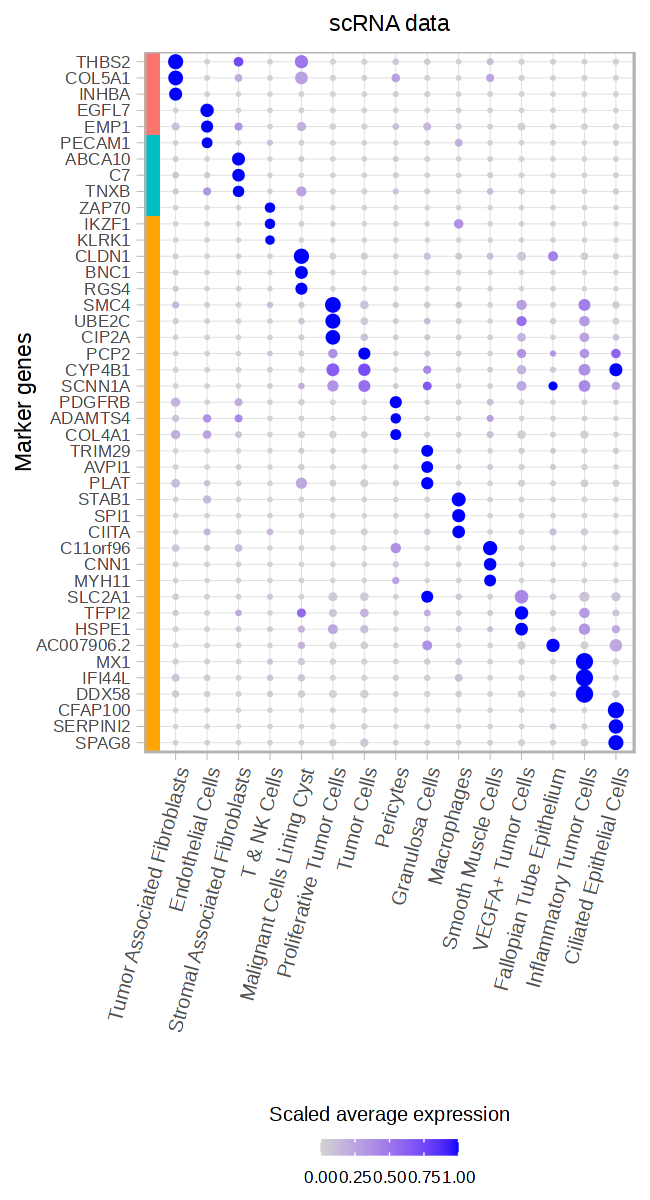

In [11]:
## now making some marker dotplots for sc and spatial data

options(repr.plot.width = 3.25, repr.plot.height = 6, repr.plot.res = 200)

sc_obj <- so_rna

# for sc first
p <- DotPlot(object = sc_obj, features = markers_plot,
            col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_sc <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) + # change to avg.exp.log or avg.exp.log.scaled or avg.exp.scaled
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('scRNA data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 75, vjust = 1, hjust=1, size=7),
        axis.text.y = element_text(size=6),
           legend.key.size = unit(6, 'pt'),
           legend.key.height = unit(6, 'pt'),
           legend.key.width = unit(10, 'pt'),
           legend.title=element_text(size=7),
           legend.text=element_text(size=6),
           legend.position="bottom",
           legend.box="vertical", legend.margin=margin()) +
           guides(colour = guide_colourbar(title.position="top", title.hjust = 0.5),
           size = 'none') +
           labs(colour="Scaled average expression") +
          annotate(
            ymin = 0, ymax = .5, # width
            xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
            geom = "rect",
            fill = c("orange", "#00BFC4", "#F8766D"))


p_sc



Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


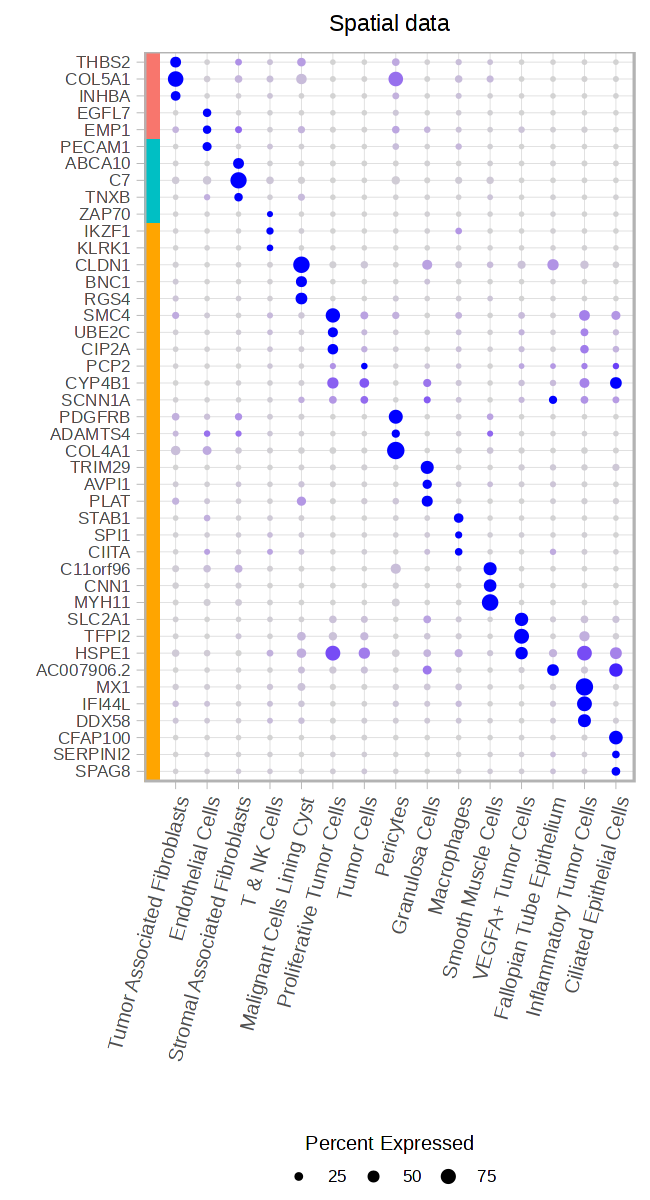

In [12]:
# now for spatial
Idents(so_spatial) <- so_spatial$cell_type
Idents(so_spatial) <- factor(Idents(so_spatial),levels(Idents(so_rna)))
p <- DotPlot(object = so_spatial, features = markers_plot,
            col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_spat <- p +
    geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) +
    coord_flip() +
    xlab('') +
    ylab('') +
    ggtitle('Spatial data') +
    theme_light(base_line_size = gg_line_thickness) +
    scale_radius(range = c(0,2)) +
    p_theme +
    theme(axis.text.x = element_text(angle = 75, vjust = 1, hjust=1, size=7),
        axis.text.y = element_text(size=6),
           legend.key.size = unit(6, 'pt'),
           legend.key.height = unit(6, 'pt'),
           legend.key.width = unit(10, 'pt'),
           legend.title=element_text(size=7),
           legend.text=element_text(size=6),
           legend.position="bottom",
           legend.box="vertical", legend.margin=margin()) +
           guides(colour = 'none',
           size = guide_legend(title.position="top", title.hjust = 0.5)) +
           labs(size="Percent Expressed") +
    annotate(
    ymin = 0, ymax = .5, # width
    xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
    geom = "rect",
    fill = c("orange", "#00BFC4", "#F8766D"))

p_spat

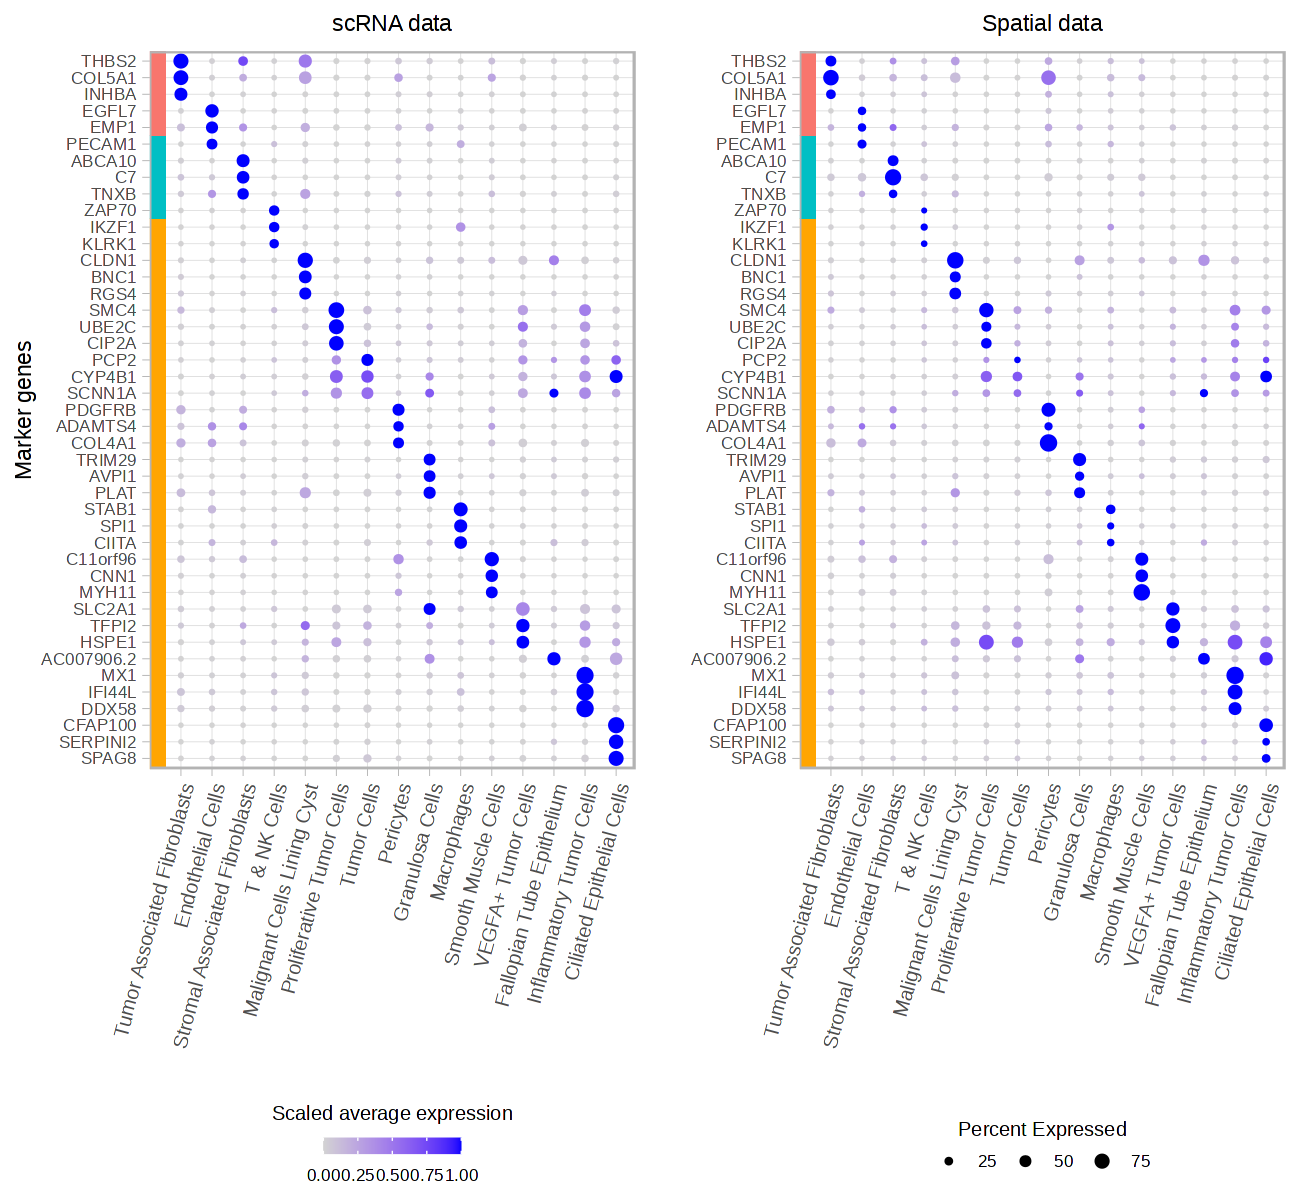

In [13]:
options(repr.plot.width = 6.5, repr.plot.height = 6, repr.plot.res = 200)

fig <- cowplot::plot_grid(p_sc,p_spat,nrow=1,align='hv')
fig

In [14]:
pdf(OutputPath('oc_sc_spatial_marker_dotplots.pdf'), useDingbats=FALSE, width=6.5, height=6)
fig
dev.off()

png 
  2